## Prepare Notebook

In [2]:
import pandas as pd
import numpy as np
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
excel_path = r"../../static/mock/AntiBio2.xlsx"

In [4]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df_compounds = tables_dict["CompoundsData"]['dataframe']
df_bacterias = tables_dict["BacteriasData"]['dataframe']
df_experiments = tables_dict["ExperimentsData"]['dataframe']


worksheet name: Table
tables in worksheet: 0

worksheet name: CompoundsData
tables in worksheet: 1
table name: CompoundsData

worksheet name: BacteriasData
tables in worksheet: 1
table name: BacteriasData

worksheet name: ExperimentsData
tables in worksheet: 1
table name: ExperimentsData

worksheet name: Legend-Main
tables in worksheet: 0

worksheet name: Bac
tables in worksheet: 0


In [5]:
df_experiments.columns

Index(['REE', 'Bacteria', 'Is salt', 'Stunting diameter'], dtype='object')

In [6]:
df_compounds.columns

Index(['REE', 'Ionic radii', 'X', 'Electronegativity, Oganov',
       'Electronegativity, Malliken', 'Electronegativity, Poland',
       'Crystal structure type', 'Ln-O', 'Ln-N',
       'Coordination number solution, Ln-O',
       'Coordination number solution, Ln-N', 'рН', 'lgβ',
       'Electronic structure RE3+', 'Price'],
      dtype='object')

In [7]:
df_bacterias.columns

Index(['Name', 'Gram-stain', 'Wall thickness min', 'Wall thickness max',
       'Wall structure', 'Wall composition 1', 'Wall composition 2',
       'Outer membrane', 'Membrane pore diameter min',
       'Membrane pore diameter max', 'Proteins', 'Penicillin sensitivity',
       'Well layers'],
      dtype='object')

In [8]:
df = df_experiments.merge(df_compounds, left_on='REE', right_on='REE').merge(df_bacterias, left_on='Bacteria', right_on='Name')
df.head().columns

Index(['REE', 'Bacteria', 'Is salt', 'Stunting diameter', 'Ionic radii', 'X',
       'Electronegativity, Oganov', 'Electronegativity, Malliken',
       'Electronegativity, Poland', 'Crystal structure type', 'Ln-O', 'Ln-N',
       'Coordination number solution, Ln-O',
       'Coordination number solution, Ln-N', 'рН', 'lgβ',
       'Electronic structure RE3+', 'Price', 'Name', 'Gram-stain',
       'Wall thickness min', 'Wall thickness max', 'Wall structure',
       'Wall composition 1', 'Wall composition 2', 'Outer membrane',
       'Membrane pore diameter min', 'Membrane pore diameter max', 'Proteins',
       'Penicillin sensitivity', 'Well layers'],
      dtype='object')

In [9]:
df.dtypes

REE                                    object
Bacteria                               object
Is salt                                 int64
Stunting diameter                       int64
Ionic radii                           float64
X                                     float64
Electronegativity, Oganov             float64
Electronegativity, Malliken           float64
Electronegativity, Poland             float64
Crystal structure type                  int64
Ln-O                                  float64
Ln-N                                  float64
Coordination number solution, Ln-O    float64
Coordination number solution, Ln-N    float64
рН                                    float64
lgβ                                   float64
Electronic structure RE3+              object
Price                                  object
Name                                   object
Gram-stain                            float64
Wall thickness min                    float64
Wall thickness max                

## Utilities

In [10]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


In [11]:
def draw_importance(importances, model_name, columns, image_path=None):
    features = {}
    color1 = "#2D466D"
    color2 = "#A2B0C5"
    for i, feature in enumerate(columns):
        features[f"f{i+1}"] = feature

    indices = np.argsort(importances)[::-1]
    num_to_plot = len(columns)
    feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

    print("Feature ranking:")
    for f in range(num_to_plot):
        print(
            "%d. %s %f "
            % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
        )
    plt.figure(figsize=(20, 10))
    bars = plt.bar(
        range(num_to_plot),
        importances[indices[:num_to_plot]],
        color=get_color_gradient(color1, color2, num_to_plot),
        align="center",
    )
    ticks = plt.xticks(range(num_to_plot), feature_indices, fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlim([-1, num_to_plot])
    plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices], fontsize="20");
    plt.title(f"Feature importance in {model_name}")
    if image_path:
        plt.savefig(image_path, format='eps', dpi=600, bbox_inches='tight', transparent="True", pad_inches=0)
    

### Models runners

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 

In [13]:
def run_rforest(X, y):
    parameters = {
    'n_estimators': range(50, 1000, 50),
    'max_depth': [None] + list(range(1, 15, 1))}

    model = RandomForestRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'r2'],
        refit='neg_mean_absolute_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    print("MAE: ", -clf.best_score_)
    print(clf.best_params_)
    print("R2: ", clf.cv_results_['mean_test_r2'].max())
    return best_model

In [14]:
def run_gradient_boosting(X, y):
    parameters = {
    'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators': [2, 4, 8, 16, 32, 64, 100, 200, 300, 400],
    'max_depth': range(1, 18, 1)}

    model = GradientBoostingRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'r2'],
        refit='neg_mean_absolute_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    print("MAE: ", -clf.best_score_)
    print(clf.best_params_)
    print("R2: ", clf.cv_results_['mean_test_r2'].max())
    return best_model

In [15]:
def run_xgboost(X, y):
    parameters = {
        'min_child_weight': [1, 5, 7, 10, 11, 12, 15,],
        'gamma': [0.5, 1, 1.5, 2, 2.5, 3, 5],
        'subsample': [0.4, 0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'r2'],
        refit='neg_mean_absolute_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    print("MAE: ", -clf.best_score_)
    print(clf.best_params_)
    print("R2: ", clf.cv_results_['mean_test_r2'].max())
    return best_model

## Data exploration

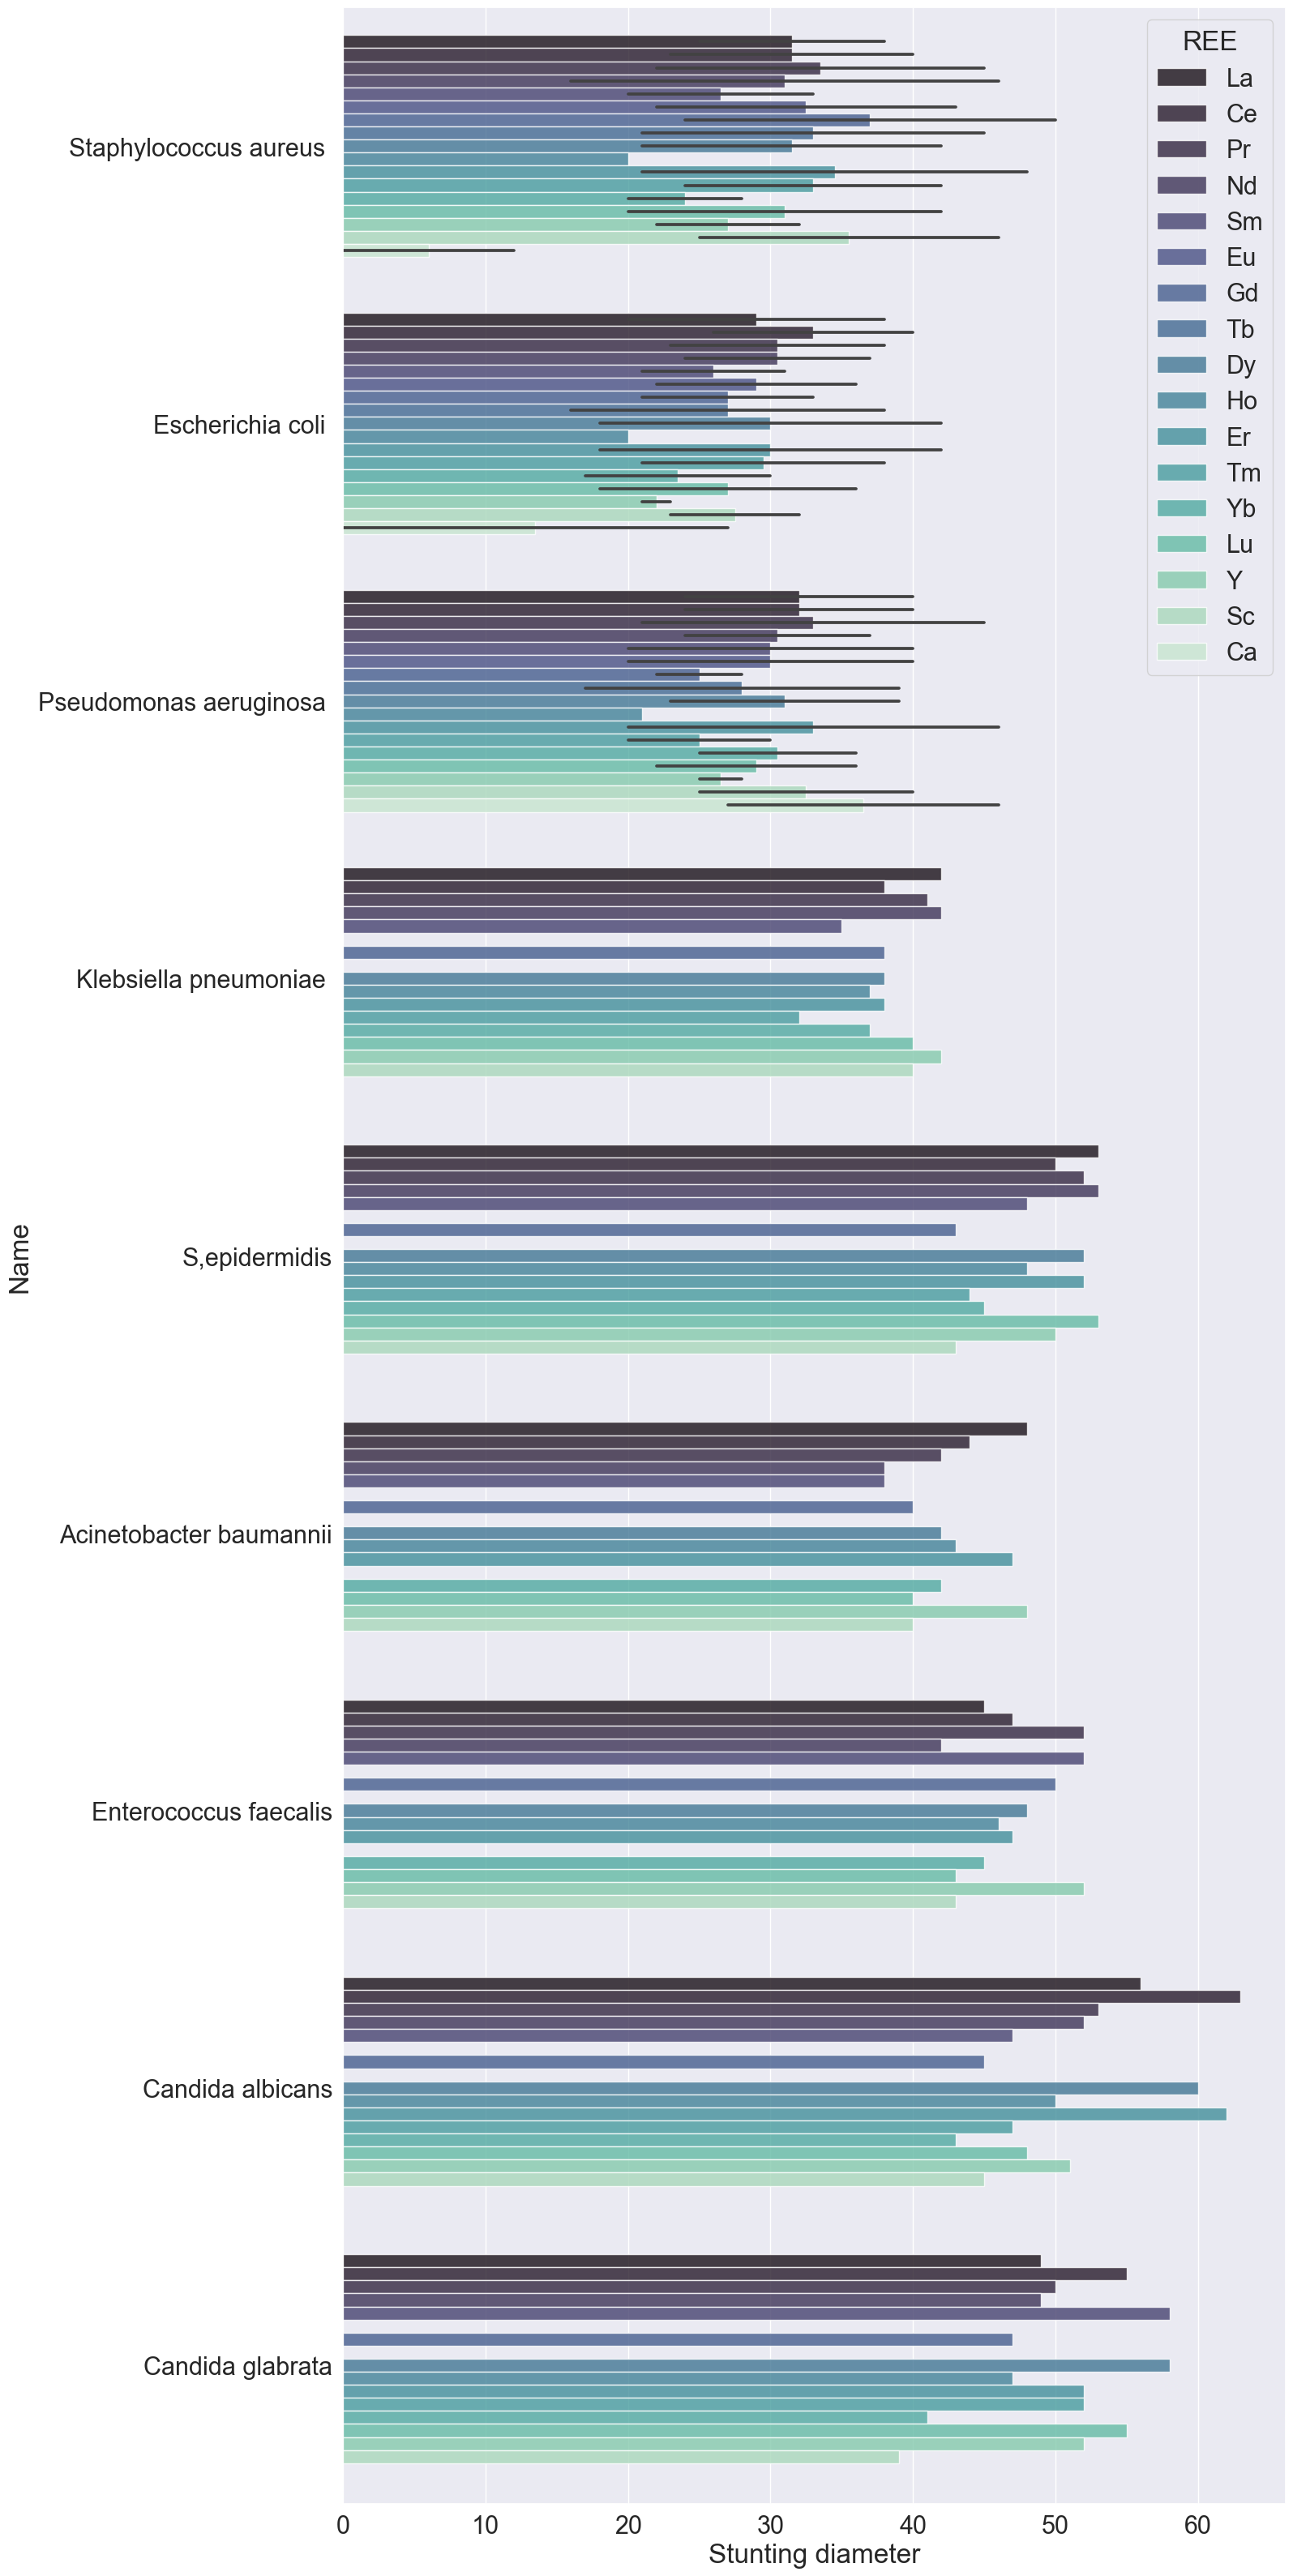

In [148]:
plt.figure(figsize=(15, 40))
sns.set(font_scale=2)
sns.barplot(data=df, y='Name', x='Stunting diameter', hue='REE', palette='mako', orient='h', alpha=0.8)
plt.savefig(f'../mock/Stunting diameter bars.svg', format='svg', dpi=600, bbox_inches='tight', transparent="True", pad_inches=0)

In [149]:
slice = df[['Name', 'REE', 'Stunting diameter', 'Is salt']]
idx = slice.groupby(['Name'])['Stunting diameter'].transform(max) == df['Stunting diameter']
slice[idx].sort_values('Stunting diameter', ascending=False).reset_index(drop=True).to_csv("../mock/state.csv")

## Quike Electronegativity test

### Prepare for experiments

In [150]:
mixed_data = df[df['Is salt'] == 1][['Stunting diameter', 'Ionic radii',
                                     'Electronegativity, Oganov', 'Electronegativity, Malliken',
                                     'Electronegativity, Poland', 'Crystal structure type']]
mixed_data

,Stunting diameter,Ionic radii,"Electronegativity, Oganov","Electronegativity, Malliken","Electronegativity, Poland",Crystal structure type
1,38,1.03,2.49,3.06,1.10,1
3,40,1.01,2.61,3.05,1.12,1
5,45,0.99,2.24,3.21,1.13,2
7,46,0.98,2.11,3.72,1.14,2
9,33,0.96,1.90,2.90,1.17,2
...,...,...,...,...,...,...
176,52,0.88,2.03,3.61,1.25,4
177,41,0.87,1.78,3.12,1.10,5
178,55,0.86,2.68,2.89,1.27,7
179,52,0.90,2.52,3.26,1.22,2


In [151]:
X = mixed_data.drop('Stunting diameter', axis=1)
y = mixed_data['Stunting diameter']

### Random forest

In [152]:
best_random_forest_allen = run_rforest(X, y)

MAE:  6.627490731737919
{'max_depth': 3, 'n_estimators': 550}
R2:  -0.8171817139561078


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Feature ranking:
1. Electronegativity, Poland 0.525210 
2. Electronegativity, Oganov 0.160274 
3. Ionic radii 0.134561 
4. Electronegativity, Malliken 0.118987 
5. Crystal structure type 0.060968 


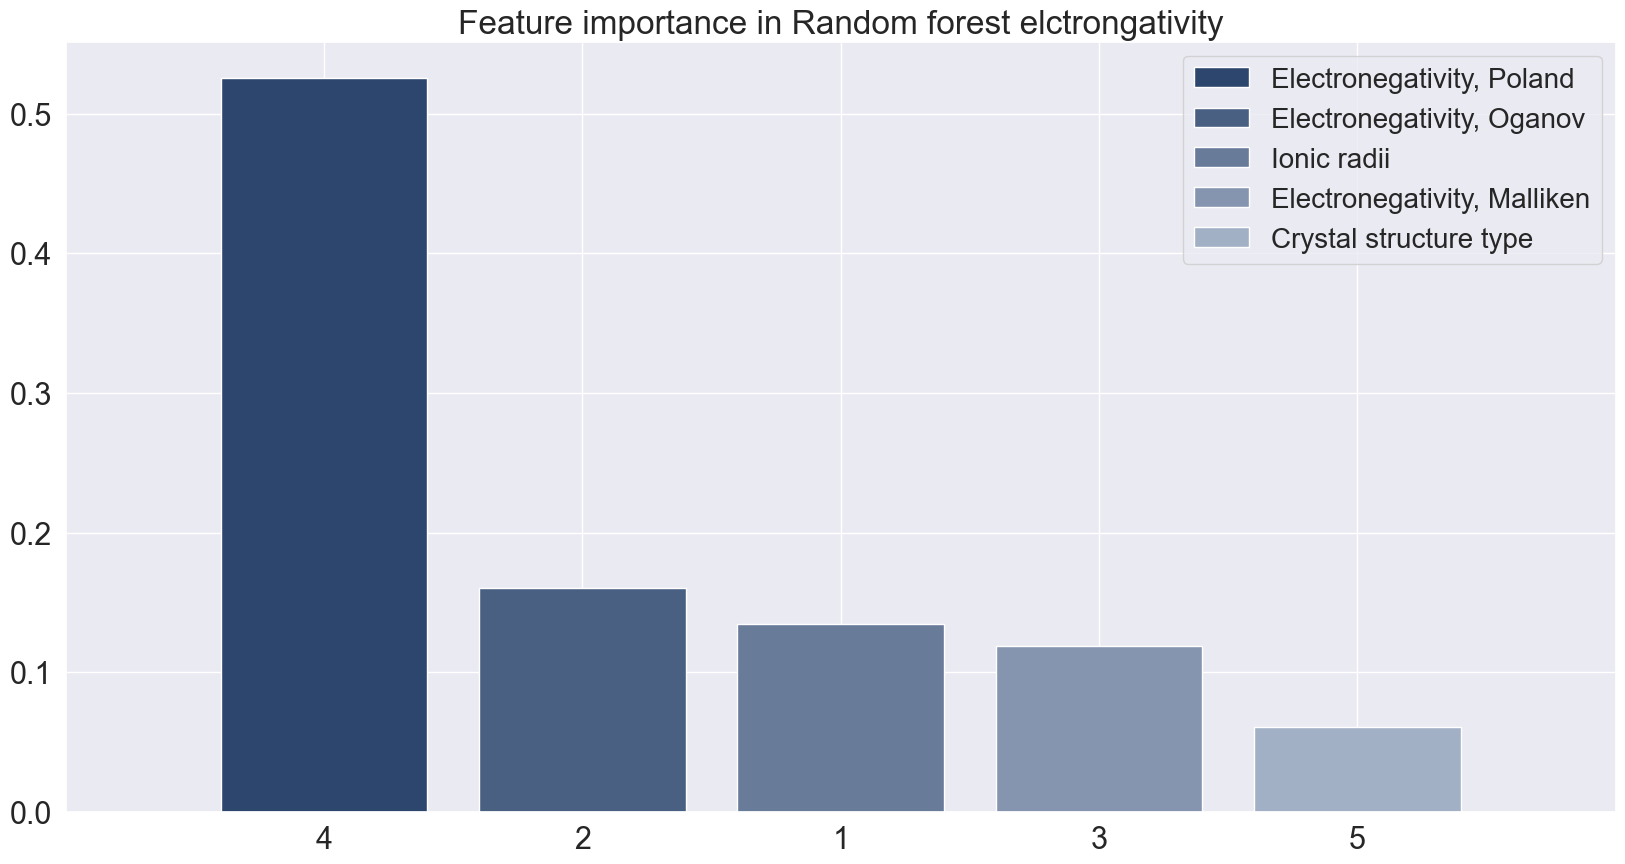

In [153]:
draw_importance(
    best_random_forest_allen.feature_importances_, 
    "Random forest elctrongativity",
    columns=X.columns,
    image_path="../mock/RundomForestAllEN.eps"
)

### Gradient boosting

In [154]:
best_gradient_boost_allen = run_gradient_boosting(X, y)

MAE:  6.597279398941112
{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 2}
R2:  -0.835906215808025


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Feature ranking:
1. Electronegativity, Poland 0.782973 
2. Crystal structure type 0.217027 
3. Electronegativity, Malliken 0.000000 
4. Electronegativity, Oganov 0.000000 
5. Ionic radii 0.000000 


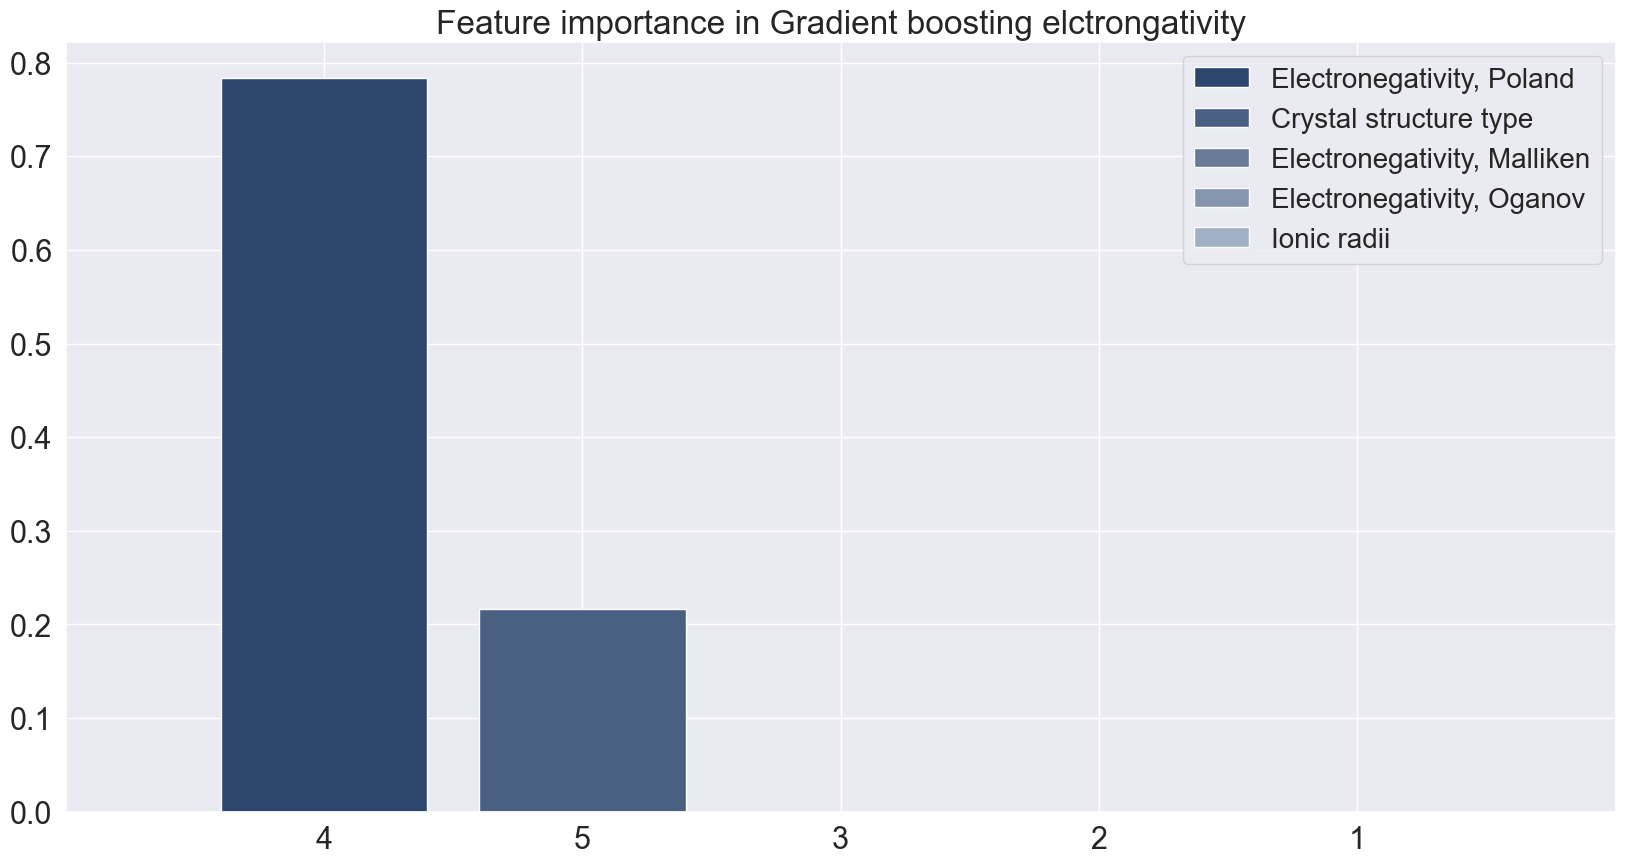

In [155]:
draw_importance(
    best_gradient_boost_allen.feature_importances_,
    "Gradient boosting elctrongativity",
    columns=X.columns,
    image_path="../mock/GradientBoostingAllEN.eps"
)

### XGBoost

In [156]:
best_xgboost_allen = run_xgboost(X, y)

MAE:  6.6626788946298445
{'colsample_bytree': 0.6, 'gamma': 5, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.4}
R2:  -0.8399087067109612


Feature ranking:
1. Crystal structure type 0.259114 
2. Electronegativity, Poland 0.199634 
3. Electronegativity, Malliken 0.195918 
4. Electronegativity, Oganov 0.184685 
5. Ionic radii 0.160649 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


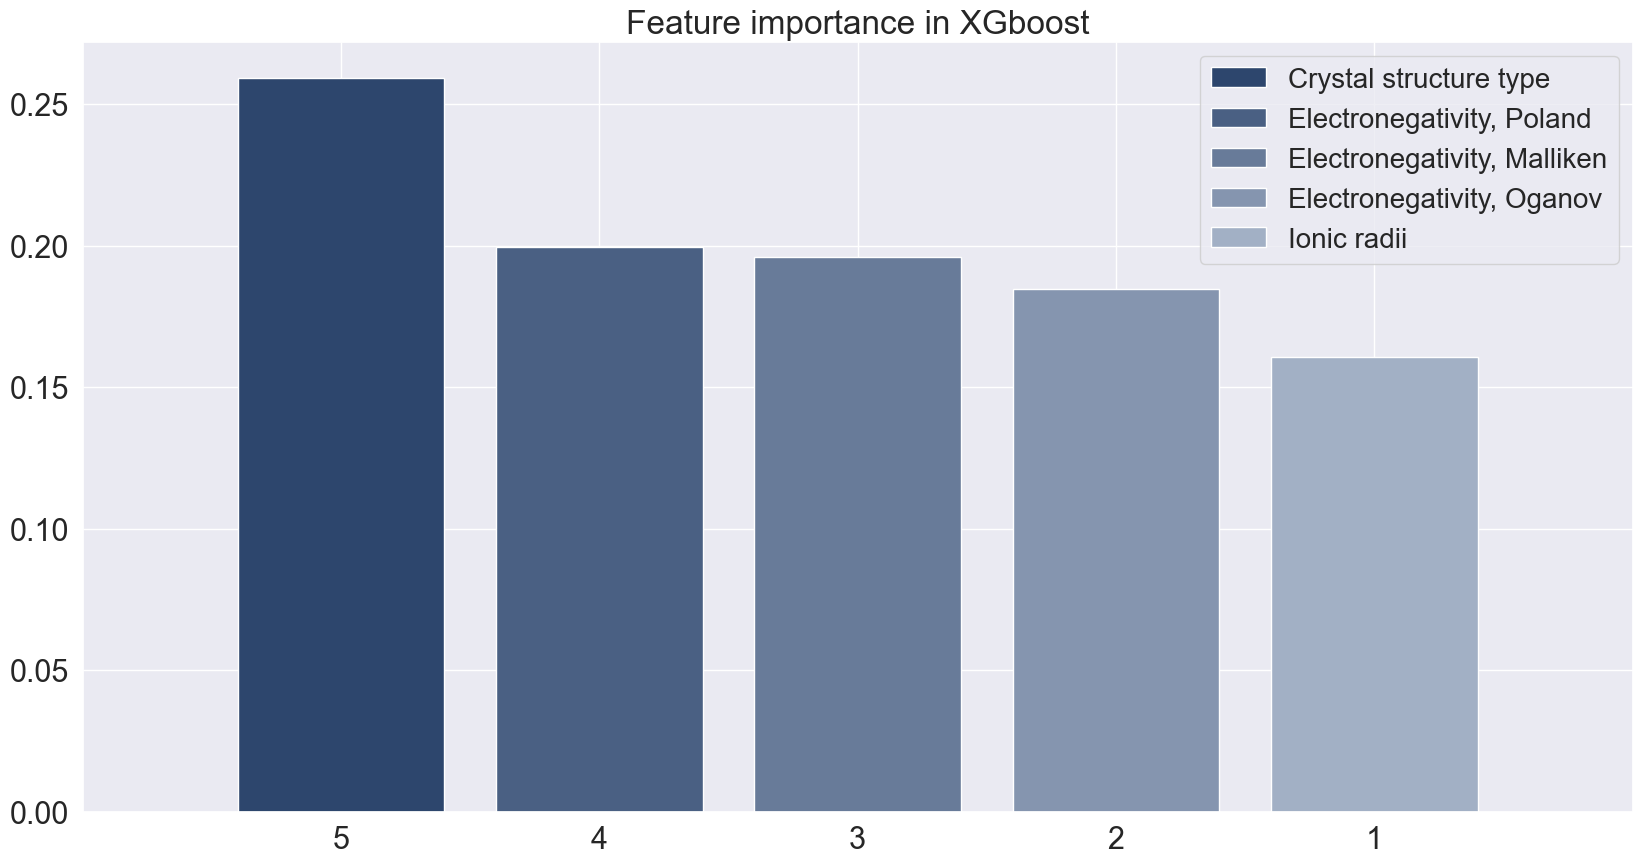

In [157]:
draw_importance(
    best_xgboost_allen.feature_importances_, 
    "XGboost",
    columns=X.columns,
    image_path="../mock/XGBoost.eps"
)

### Test MAE and R2 with different sets

In [158]:
X_oganov = X.drop(['Electronegativity, Malliken', 'Electronegativity, Poland'], axis=1)
best_rf_oganov = run_rforest(X_oganov, y)
best_gb_oganov = run_gradient_boosting(X_oganov, y)
best_xgboost_oganov = run_xgboost(X_oganov, y)

MAE:  6.631369361472805
{'max_depth': 3, 'n_estimators': 500}
R2:  -0.8305813293343125
MAE:  6.6154665608002805
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 16}
R2:  -0.8403678122377377
MAE:  6.676898486797626
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.4}
R2:  -0.8435661633348748


In [159]:
X_malliken = X.drop(['Electronegativity, Oganov', 'Electronegativity, Poland'], axis=1)
best_rf_malliken = run_rforest(X_malliken, y)
best_gb_malliken = run_gradient_boosting(X_malliken, y)
best_xgboost_malliken = run_xgboost(X_malliken, y)

MAE:  6.609924262982053
{'max_depth': 3, 'n_estimators': 550}
R2:  -0.8133969858080136
MAE:  6.583092092576527
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 16}
R2:  -0.8313610821653634
MAE:  6.682102188697229
{'colsample_bytree': 1.0, 'gamma': 2, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5}
R2:  -0.8366766273089699


In [160]:
X_poland = X.drop(['Electronegativity, Oganov', 'Electronegativity, Malliken'], axis=1)
best_rf_poland = run_rforest(X_poland, y)
best_gb_poland = run_gradient_boosting(X_poland, y)
best_xgboost_poland = run_xgboost(X_poland, y)

## Solutions Electronegativity

In [38]:
solutions_mixed = df[df['Is salt'] == 0][['Stunting diameter', 'Electronegativity, Oganov', 'Electronegativity, Malliken',
                                          'Electronegativity, Poland', 'Ln-O', 'Ln-N',
                                          'Coordination number solution, Ln-O',
                                          'Coordination number solution, Ln-N', 'рН', 'lgβ']]

In [39]:
X = solutions_mixed.drop('Stunting diameter', axis=1)
y = solutions_mixed['Stunting diameter']

In [40]:
best_xgboost_solutionsen = run_xgboost(X, y)

MAE:  3.3058927466652612
{'colsample_bytree': 0.4, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.4}
R2:  -0.3329861221571187


Feature ranking:
1. рН 0.133736 
2. lgβ 0.129675 
3. Electronegativity, Oganov 0.122409 
4. Coordination number solution, Ln-O 0.116375 
5. Electronegativity, Poland 0.107507 
6. Electronegativity, Malliken 0.104923 
7. Coordination number solution, Ln-N 0.100041 
8. Ln-O 0.093941 
9. Ln-N 0.091392 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


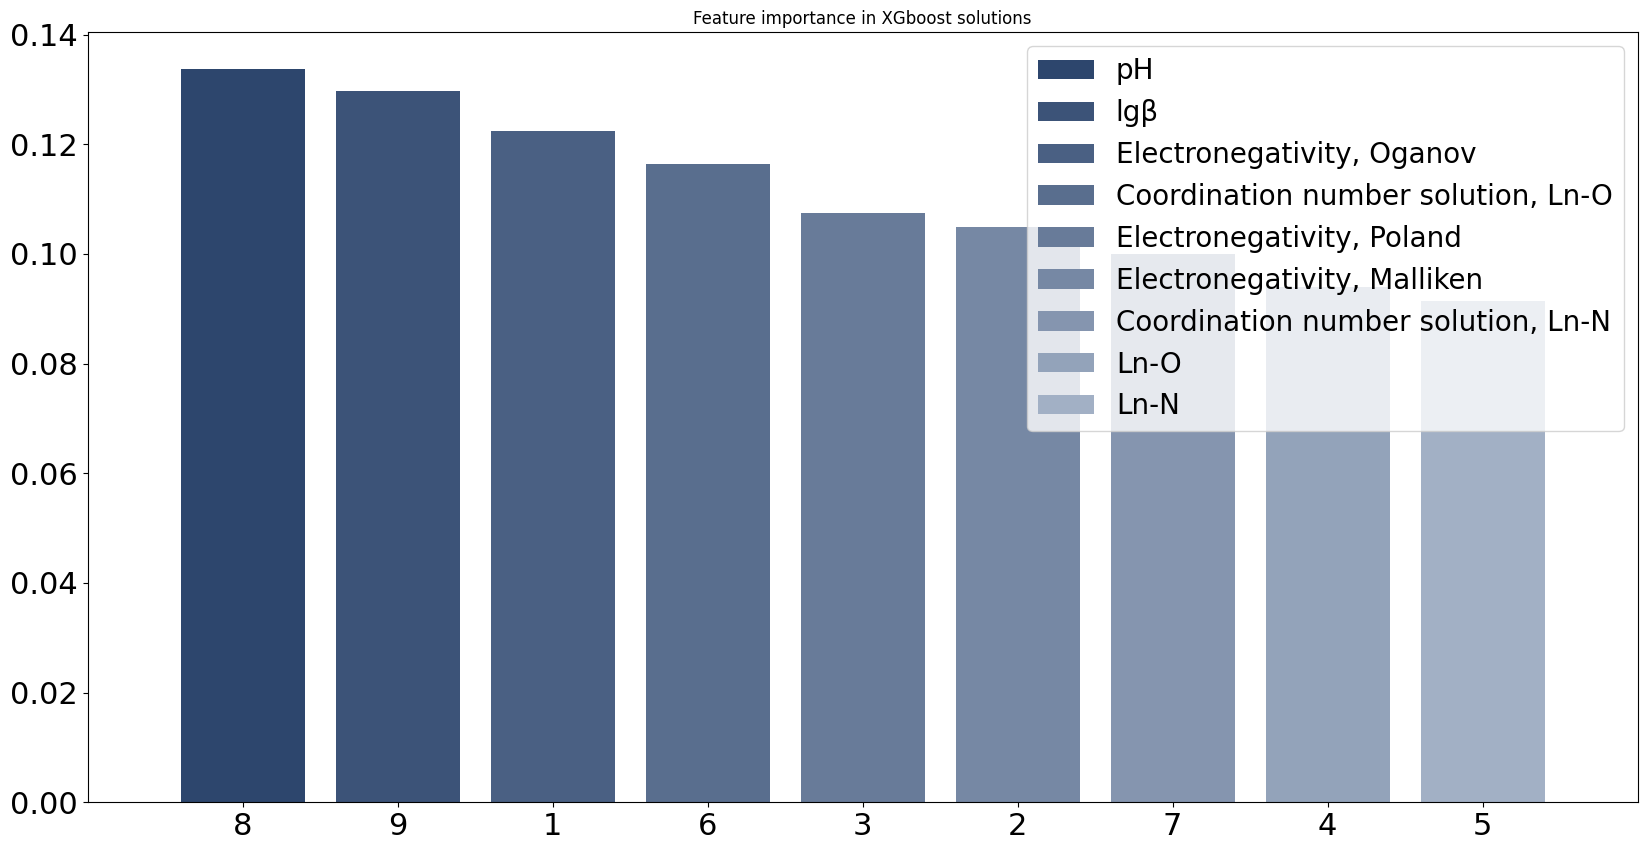

In [41]:
draw_importance(
    best_xgboost_solutionsen.feature_importances_, 
    "XGboost solutions",
    columns=X.columns,
    image_path="../mock/XGBoost.eps"
)

In [42]:
X_oganov = X.drop(['Electronegativity, Malliken', 'Electronegativity, Poland'], axis=1)
X_malliken = X.drop(['Electronegativity, Oganov', 'Electronegativity, Poland'], axis=1)
X_poland = X.drop(['Electronegativity, Oganov', 'Electronegativity, Malliken'], axis=1)
best_xgboost_oganov = run_xgboost(X_oganov, y)
best_xgboost_malliken = run_xgboost(X_malliken, y)
best_xgboost_poland = run_xgboost(X_poland, y)

MAE:  3.283936396512118
{'colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.4}
R2:  -0.3422277871427515
MAE:  3.319052425731312
{'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.4}
R2:  -0.34422557701635925
MAE:  3.3142261401089756
{'colsample_bytree': 0.4, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.4}
R2:  -0.3382205022517501


## Bacterias properties

In [21]:
bacterias_data = df[df['Is salt'] == 1][['Stunting diameter', 'Ionic radii',
                                         'Electronegativity, Oganov', 'Electronegativity, Malliken',
                                         'Electronegativity, Poland', 'Crystal structure type', 'Gram-stain',
                                         'Wall thickness min', 'Wall thickness max', 'Wall structure',
                                         'Wall composition 1', 'Wall composition 2', 'Outer membrane',
                                         'Membrane pore diameter min', 'Membrane pore diameter max', 'Proteins',
                                         'Penicillin sensitivity', 'Well layers']]
bacterias_data = bacterias_data.dropna()

In [23]:
X = bacterias_data.drop('Stunting diameter', axis=1)
y = bacterias_data['Stunting diameter']

### Random forest 

In [26]:
best_random_forest_bacterias = run_rforest(X, y)

MAE:  4.629300822792944
{'max_depth': 2, 'n_estimators': 550}
R2:  -0.36416583398905966


Feature ranking:
1. Electronegativity, Poland 0.368405 
2. Wall thickness max 0.060118 
3. Wall structure 0.054490 
4. Wall composition 2 0.053326 
5. Gram-stain 0.052133 
6. Proteins 0.051956 
7. Well layers 0.049163 
8. Penicillin sensitivity 0.048950 
9. Wall thickness min 0.047618 
10. Wall composition 1 0.045483 
11. Outer membrane 0.044557 
12. Membrane pore diameter max 0.044234 
13. Electronegativity, Oganov 0.030700 
14. Electronegativity, Malliken 0.026145 
15. Ionic radii 0.015419 
16. Crystal structure type 0.007302 
17. Membrane pore diameter min 0.000000 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


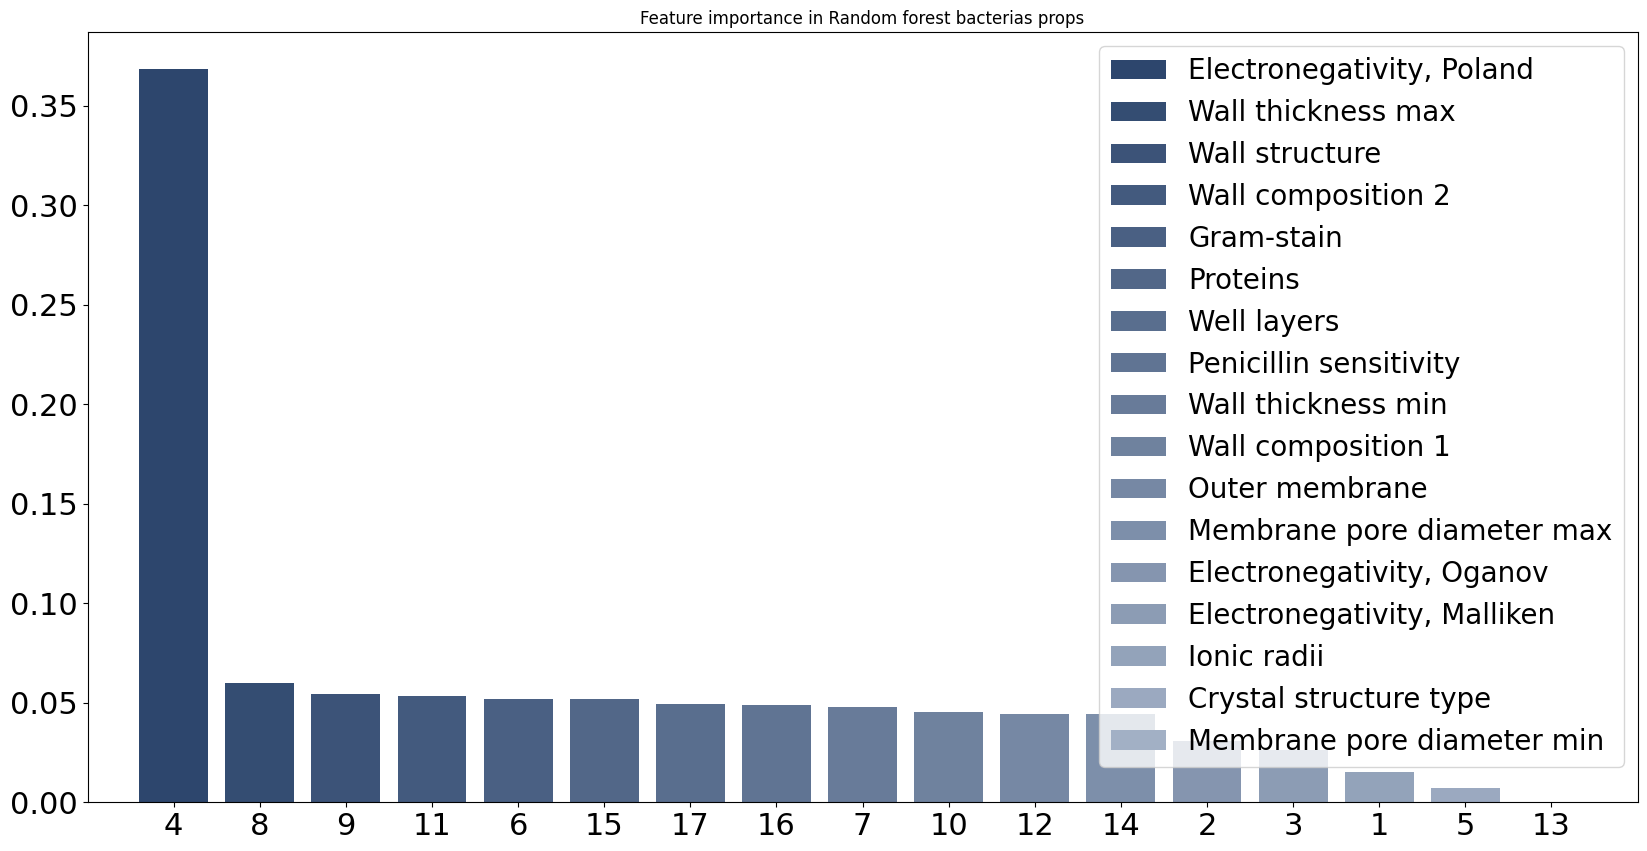

In [34]:
draw_importance(
    best_random_forest_bacterias.feature_importances_, 
    "Random forest bacterias props",
    columns=X.columns,
    image_path="../mock/RundomForestAllEN.eps"
)

### Geadient boosting

In [28]:
best_gradient_boost_bacterias = run_gradient_boosting(X, y)

MAE:  4.704389894208433
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}
R2:  -0.40621974247716147


Feature ranking:
1. Electronegativity, Malliken 0.444735 
2. Electronegativity, Oganov 0.062936 
3. Membrane pore diameter max 0.054411 
4. Gram-stain 0.048413 
5. Proteins 0.045407 
6. Wall structure 0.042437 
7. Outer membrane 0.042231 
8. Ionic radii 0.038502 
9. Penicillin sensitivity 0.038436 
10. Well layers 0.035850 
11. Wall thickness min 0.031010 
12. Wall thickness max 0.028531 
13. Wall composition 1 0.026645 
14. Wall composition 2 0.021021 
15. Crystal structure type 0.009404 
16. Membrane pore diameter min 0.000000 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


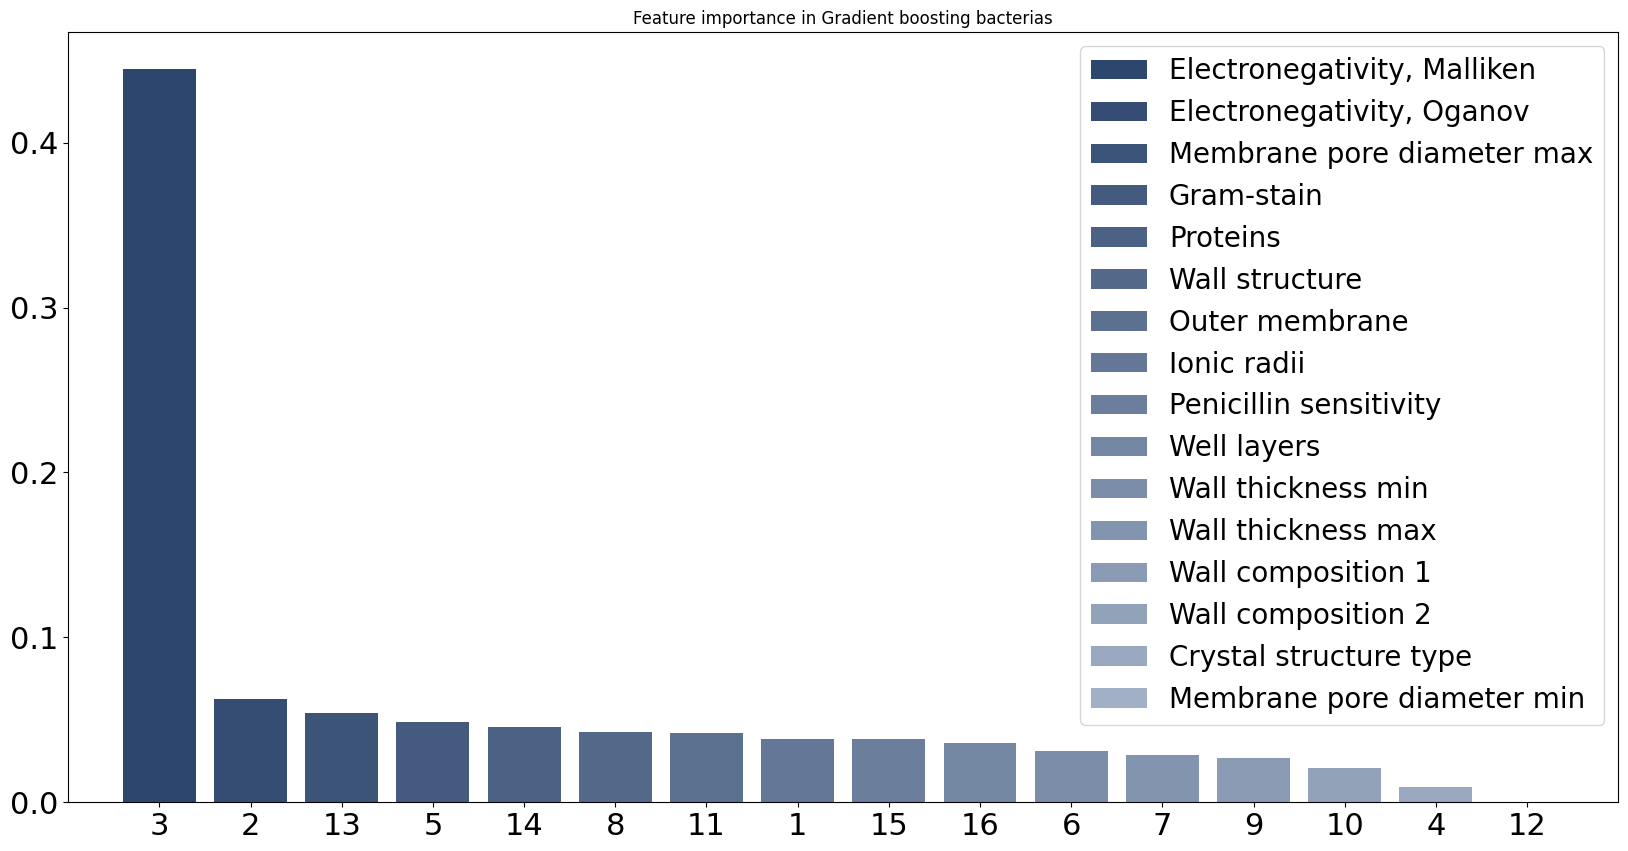

In [31]:
draw_importance(
    best_gradient_boost_bacterias.feature_importances_,
    "Gradient boosting bacterias",
    columns=X.columns,
    image_path="../mock/GradientBoostingAllEN.eps"
)

### XGBoosting

In [35]:
best_xgboost_bacterias = run_xgboost(X, y)

MAE:  4.7711864271618065
{'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.6}
R2:  -0.45453050529581757


Feature ranking:
1. Gram-stain 0.292208 
2. Crystal structure type 0.190749 
3. Electronegativity, Malliken 0.154180 
4. Electronegativity, Poland 0.132875 
5. Electronegativity, Oganov 0.118002 
6. Ionic radii 0.111987 
7. Wall thickness max 0.000000 
8. Wall thickness min 0.000000 
9. Well layers 0.000000 
10. Penicillin sensitivity 0.000000 
11. Wall composition 1 0.000000 
12. Wall composition 2 0.000000 
13. Outer membrane 0.000000 
14. Membrane pore diameter min 0.000000 
15. Membrane pore diameter max 0.000000 
16. Proteins 0.000000 
17. Wall structure 0.000000 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


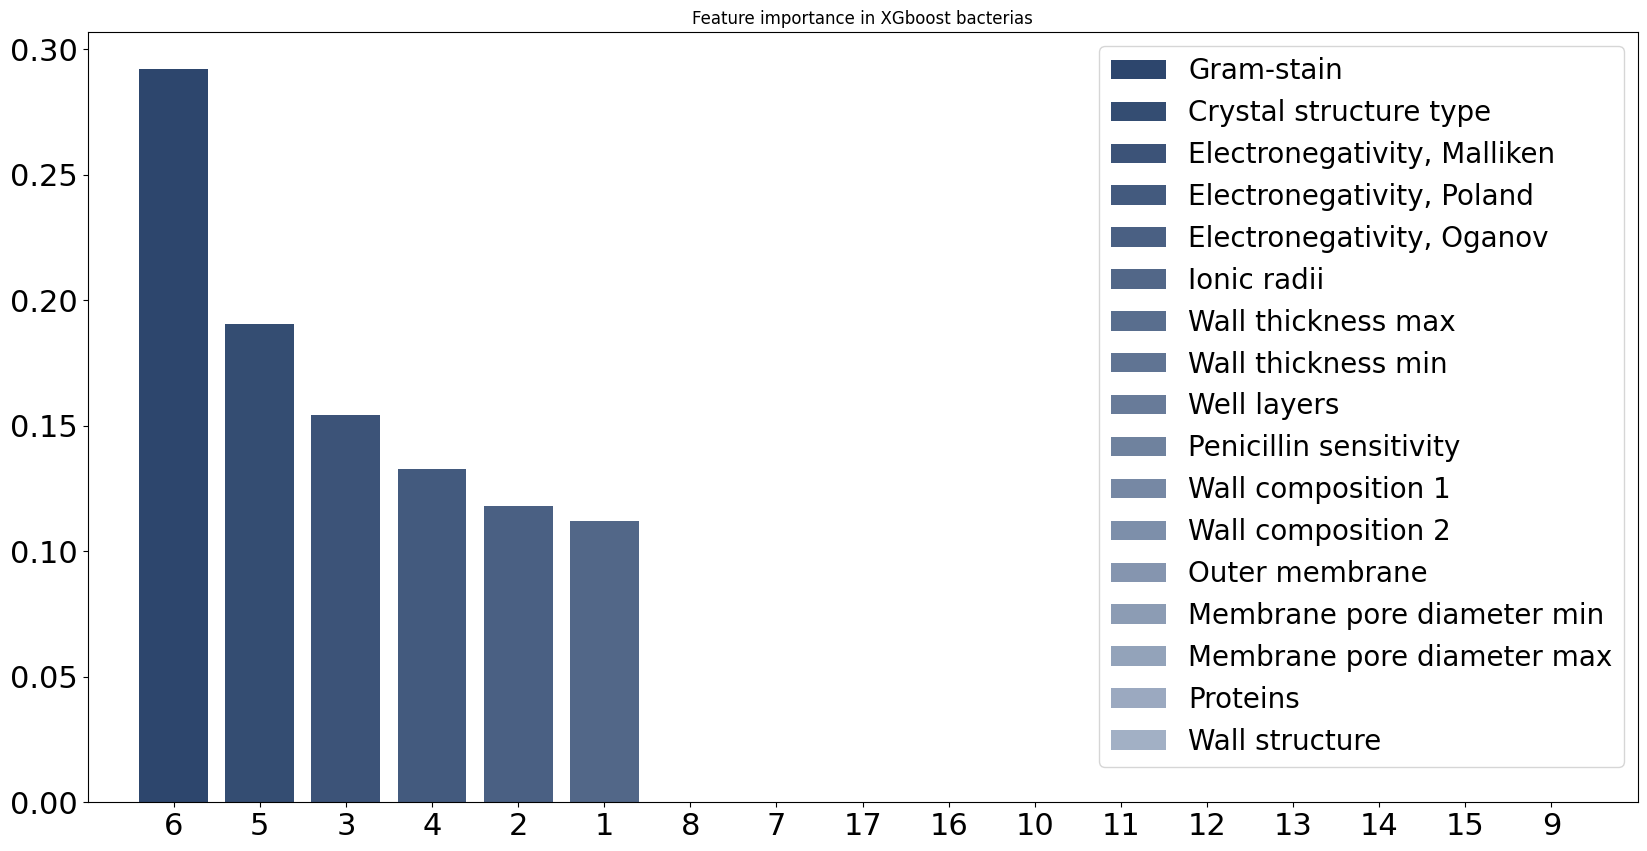

In [36]:
draw_importance(
    best_xgboost_bacterias.feature_importances_, 
    "XGboost bacterias",
    columns=X.columns,
    image_path="../mock/XGBoost.eps"
)